# Evaluation Metrics


In [7]:
pip install rouge_score

In [20]:
import torch
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import time
import numpy as np
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate import meteor_score
import nltk
import matplotlib.pyplot as plt

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Define the paths where the model and tokenizer are saved
gpt_model_path = "/content/drive/MyDrive/Colab Notebooks/AAI-520/Final Project/GenAI-Chatbot/eval/gpt/base_gpt_model_3_actual"
gpt_tokenizer_path = "/content/drive/MyDrive/Colab Notebooks/AAI-520/Final Project/GenAI-Chatbot/eval/gpt/base_gpt_tokenizer_3_actual"
full_dataset_path = "/content/drive/MyDrive/Colab Notebooks/AAI-520/Final Project/GenAI-Chatbot/dataset.csv"  # Full dataset path

# Load the model and tokenizer
model = GPT2LMHeadModel.from_pretrained(gpt_model_path)
tokenizer = GPT2Tokenizer.from_pretrained(gpt_tokenizer_path)
tokenizer.pad_token = tokenizer.eos_token
#tokenizer.padding_side = 'left'  # Use left-padding for generation

In [11]:
# Set the model to evaluation mode
model.eval()

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load the full dataset
chatbot_dataset = pd.read_csv(full_dataset_path)

# Sample 30% of the dataset before splitting
#sampled_dataset = chatbot_dataset.sample(frac=0.3, random_state=42)

# Split the dataset into train and test sets (80% train, 20% test)
train_data, test_data = train_test_split(chatbot_dataset, test_size=0.2, random_state=42)

# Further split the train data into training and validation sets (80% train, 20% validation)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Display the sizes of the sampled datasets
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 141674
Validation set size: 35419
Test set size: 44274


In [12]:
from torch.utils.data import Dataset, DataLoader

# Define a new dataset class to maintain context with limited history and turn markers
class ContextualChatbotDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=100, history_window=3):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.history_window = history_window  # Number of turns to retain in history

    def __getitem__(self, idx):
        # Get the conversation history and the response
        conversation_history = self.data['conversation_history'].iloc[idx].split(" [SEP] ")
        response = self.data['response'].iloc[idx]

        # Limit the conversation history to the last `history_window` turns
        limited_history = conversation_history[-self.history_window:]

        # Add special tokens for user and bot turns
        input_text = f"[USER] {' [BOT] '.join(limited_history)} [BOT] {response}"

        # Tokenize the input
        encodings = self.tokenizer.encode_plus(
            input_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
            return_attention_mask=True,
            add_special_tokens=True,
        )

        return {
            'input_ids': encodings['input_ids'].squeeze(0),  # Remove batch dimension
            'attention_mask': encodings['attention_mask'].squeeze(0),  # Remove batch dimension
            'labels': encodings['input_ids'].squeeze(0),  # Set labels to input_ids for language modeling
        }

    def __len__(self):
        return len(self.data)


val_dataset = ContextualChatbotDataset(val_data, tokenizer, history_window=3)
test_dataset = ContextualChatbotDataset(test_data, tokenizer, history_window=3)


val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4, shuffle=False)


In [13]:
# Define a function to calculate loss and perplexity with time and tqdm
def calculate_loss_and_perplexity(loader, model, device):
    model.eval()
    total_loss = 0
    total_tokens = 0
    start_time = time.time()  # Start the timer

    # Initialize tqdm progress bar
    with torch.no_grad():
        for batch in tqdm(loader, desc="Calculating Loss and Perplexity"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Compute the loss
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
            total_loss += loss.item() * input_ids.size(1)  # Sum of the loss for each token
            total_tokens += input_ids.size(1)

    avg_loss = total_loss / total_tokens
    perplexity = np.exp(avg_loss)

    end_time = time.time()  # End the timer
    elapsed_time = end_time - start_time  # Calculate total elapsed time

    return avg_loss, perplexity, elapsed_time

# Calculate loss and perplexity on the validation dataset
avg_loss, perplexity, elapsed_time = calculate_loss_and_perplexity(val_loader, model, device)
print(f"Average Loss: {avg_loss:.4f}, Perplexity: {perplexity:.4f}, Time taken: {elapsed_time:.2f} seconds")

Calculating Loss and Perplexity: 100%|██████████| 1107/1107 [02:33<00:00,  7.23it/s]

Average Loss: 0.7615, Perplexity: 2.1415, Time taken: 153.15 seconds


In [14]:
# Calculate loss and perplexity on the test dataset
avg_loss, perplexity, elapsed_time = calculate_loss_and_perplexity(test_loader, model, device)
print("Test Loader \n")
print(f"Average Loss: {avg_loss:.4f}, Perplexity: {perplexity:.4f}, Time taken: {elapsed_time:.2f} seconds")

Calculating Loss and Perplexity: 100%|██████████| 1384/1384 [03:11<00:00,  7.24it/s]

Test Loader 

Average Loss: 0.7632, Perplexity: 2.1452, Time taken: 191.09 seconds


In [15]:
# Function to generate predictions using the model
def generate_predictions(loader, model, device):
    model.eval()
    predictions = []
    references = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Generating Predictions"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Generate predictions
            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=100)
            predictions.extend([tokenizer.decode(output, skip_special_tokens=True) for output in outputs])
            references.extend([tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids])  # Actual input used as reference

    return references, predictions

# Generate predictions for the test dataset
references, predictions = generate_predictions(test_loader, model, device)

Generating Predictions:   0%|          | 0/1384 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Generating Predictions:   0%|          | 1/1384 [00:01<39:53,  1.73s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Generating Predictions:   0%|          | 2/1384 [00:02<21:43,  1.06it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Generating Predictions:   0%|          | 3/1384 [00:03<22

In [16]:
# Compute ROUGE scores
def compute_rouge(references, predictions):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {}

    for reference, prediction in zip(references, predictions):
        score = scorer.score(reference, prediction)
        for key in score:
            if key not in scores:
                scores[key] = []
            scores[key].append(score[key])

    # Calculate average ROUGE scores
    avg_scores = {key: np.mean([s.fmeasure for s in scores[key]]) for key in scores}
    return avg_scores

# Calculate ROUGE scores for the predictions
rouge_scores = compute_rouge(references, predictions)

# Print the ROUGE scores
print("ROUGE Scores:")
for key, value in rouge_scores.items():
    print(f"{key}: {value:.4f}")

ROUGE Scores:
rouge1: 0.9800
rouge2: 0.9798
rougeL: 0.9800


In [17]:
reference_tokens = [[ref.split()] for ref in references]  # Tokenizing the reference
prediction_tokens = [pred.split() for pred in predictions]  # Tokenizing the predictions

# Calculate BLEU score
bleu_score = corpus_bleu(reference_tokens, prediction_tokens)

print(f"BLEU Score: {bleu_score:.4f}")

BLEU Score: 0.9134


In [18]:
# Calculate METEOR score for each prediction
meteor_scores = []
for ref, pred in zip(references, predictions):
    # Tokenizing the reference and prediction into lists of words
    tokenized_ref = ref.split()  # Tokenizing the reference into a list of words
    tokenized_pred = pred.split()  # Tokenizing the prediction into a list of words

    # Calculate METEOR score using the tokenized lists directly
    score = meteor_score.single_meteor_score(tokenized_ref, tokenized_pred)
    meteor_scores.append(score)

# Calculate the average METEOR score
average_meteor = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0

print(f"Average METEOR Score: {average_meteor:.4f}")

Average METEOR Score: 0.9901


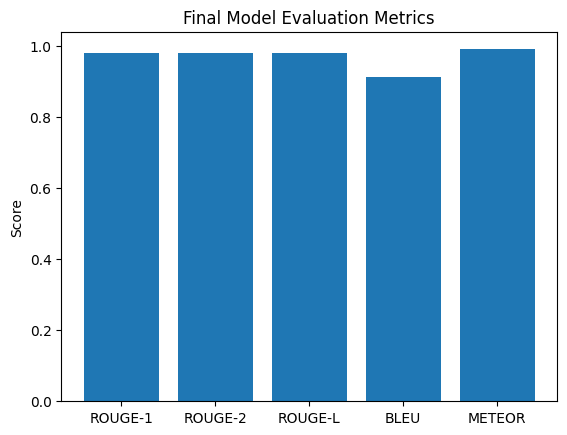

In [21]:
# Plot all the metrics on a bar chart
metrics_names = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU', 'METEOR']
metrics_values = [
    rouge_scores['rouge1'],
    rouge_scores['rouge2'],
    rouge_scores['rougeL'],
    bleu_score,
    average_meteor
]

# Create the bar chart
plt.bar(metrics_names, metrics_values)
plt.ylabel('Score')
plt.title('Final Model Evaluation Metrics')
plt.show()

# Human Feedback Evaluation

In [22]:
\model.eval()

# Check for GPU availability and move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Chatbot is ready! Type 'exit' to end the conversation.")

# Initialize conversation history
conversation_history = []

# Define a diverse set of fallback responses
fallback_responses = [
    "I'm not sure how to respond to that.",
    "Can you please rephrase your question?",
    "That's an interesting point! Tell me more.",
    "I'm still learning. Can you clarify?",
    "I don't have the answer to that right now.",
    "That's a good question! Let me think about it."
]

def ensure_punctuation(input_text):
    if input_text and input_text[-1] not in ['.', '!', '?']:
        return input_text + '.'
    return input_text

def strip_echo(user_input, response):
    # Check if the user input is part of the response (case insensitive)
    user_input_lower = user_input.lower()
    if user_input_lower in response.lower():
        # Remove the echoed part from the response
        response_cleaned = response.replace(user_input, '').strip()
        return response_cleaned
    return response

while True:
    # Get user input
    user_input = input("\nYou: ")

    if user_input.lower() == 'exit':
        print("Ending the conversation.")
        break

    user_input = ensure_punctuation(user_input)

    # Append user input to conversation history
    conversation_history.append(user_input)

    # Prepare the input for the model
    input_text = user_input

    # Tokenize the input
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=100)

    # Move the inputs to the appropriate device
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Generate a response with adjusted parameters
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=100,
            temperature=0.3,   # Increase randomness
            top_k=50,          # Limit to top 50 predictions
            top_p=0.7,        # Nucleus sampling with p=0.95
            do_sample=True      # Enable sampling
        )

    # Decode the generated response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Clean the response to avoid unwanted tokens
    response_cleaned = response.strip()
    response_cleaned = response_cleaned.replace('[USER]', '').replace('[BOT]', '').replace('SEP', '').strip()

    # Strip echoed parts from the response
    response_cleaned = strip_echo(user_input, response_cleaned)

    # Check for empty or nonsensical responses and use fallback if necessary
    if not response_cleaned or "I'm sorry" in response_cleaned:
        response_cleaned = fallback_responses[0]  # Default fallback

    # Print the model's response
    print(f"Chatbot: {response_cleaned}")

    # Append the model response to the conversation history
    conversation_history.append(response_cleaned)

Chatbot is ready! Type 'exit' to end the conversation.

You: Hello! I am greeting you!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Chatbot: Hello.

You: How are you doing today?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Chatbot: I'm calling the Mayor.

You: who is the mayor in this city?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Chatbot: This is Joe Cantwell.

You: Oh thats an interesting name. I like the name


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Chatbot: The late Mrs. Jorgensen.

You: Nah I don't like her name. But you said late. Did she die?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Chatbot: No.

You: exit
Ending the conversation.
